In [105]:
######################################################################################################################
# Author: Christopher O'Toole
# Required libraries: sklearn, pandas, numpy
# Python version: 3.6
######################################################################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [106]:
categorical_attrs = ('Is Home/Away?', 'Is Opponent in AP Top 25 at Preseason?', 'Media', 'Label: Win/Lose')
task5_categorical_attrs = ('Is_Home_or_Away','Is_Opponent_In_AP25_Preseason','Media', 'Label')
q1_train_df = pd.read_csv('Q1_train_set.csv', dtype={k: 'category' for k in categorical_attrs})
task5_training_set = pd.read_csv('task5_training_set.csv', dtype={k: 'category' for k in task5_categorical_attrs})
task5_training_set.head()
task5_testing_set = pd.read_csv('task5_testing_set.csv', dtype={k: 'category' for k in task5_categorical_attrs})

In [107]:
task5_training_set.describe()

,Is_Home_or_Away,Is_Opponent_In_AP25_Preseason,Media,Label
count,24,24,24,24
unique,2,2,5,2
top,Home,Out,1-NBC,Win
freq,15,17,14,14


In [108]:
task5_testing_set.describe()

,Date,Opponent,Is_Home_or_Away,Is_Opponent_In_AP25_Preseason,Media,Label
count,12,12,12,12,12,12
unique,12,12,2,2,4,2
top,10/7/2017,Stanford,Home,Out,1-NBC,Win
freq,1,1,7,8,7,9


In [109]:
######################################################################################################################
# What follows is an implementation of the CART, ID3, and C4.5 decision tree algorithms written 
# from scratch!
#
# This completes the programming required by Task 3.
#
# Gimme that extra credit pls.
######################################################################################################################

from graphviz import Digraph
import math

class TreeNode():
    def __init__(self, partition_df, label, mode_label):
        self.mode_label = mode_label
        self.data = partition_df
        self.label = label
        self.children = []
        self._children_labels = []
        self._split_feature = ''
            
    def partition(self, feature):
        # Performs a multi-way split with each distinct category representing one edge.
        # This operation partitions the data without actually modifying the current internal
        # tree structure.
        feature_column = self.data[feature]
        children = []
        categories = []
        for category in feature_column.unique():
            children.append(TreeNode(self.data[feature_column == category], self.label, self.mode_label))
            categories.append(category)
    
        return children, categories
        
    def split(self, feature):
        # Use this method when splitting the data instances on a particular feature
        # is desired. This WILL modify the current tree.
        self.children, self._children_labels = self.partition(feature)
        self._split_feature = feature
        
    def count(self):
        # Length of the data partitioned into this node.
        return self.data.count()[0]
    
    def gain(self, w, children):
        # information gain metric
        return self.entropy-w.dot(np.array([node.entropy for node in children]))
    
    def gain_ratio(self, w, children):
        # gain ratio metric
        return self.gain(w, children)/(-w.dot(np.log2(w))+1e-9)
    
    def gini_index(self, w, children):
        # gini index metric
        return -w.dot(np.array([node.gini for node in children]))
    
    def evaluate_split(self, feature, measure='gain_ratio'):
        # evaluates a split without modifying the current tree representation
        # information gain, gini, and gain ratio are all supported measures
        # for split evaluation
        children, _ = self.partition(feature)
        w = np.asarray([node.count() for node in children])/self.count()
        return getattr(self, measure)(w, children)

    @property
    def children(self):
        # this node's children
        return self._children
    
    @property
    def children_labels(self):
        # the attribute values that correspond to selecting each child node
        return self._children_labels
    
    @children.setter
    def children(self, value):
        self._children = value
    
    @property
    def label(self):
        # key value for the label feature
        return self._label
    
    @label.setter
    def label(self, value):
        self._label = value
    
    @property
    def data(self):
        # this node's partition of data
        return self._data
    
    @data.setter
    def data(self, value):
        self._data = value
    
    @property
    def class_label(self):
        # should only be used for leaf nodes
        # this is the best guess for which class a set of data
        # belongs to.
        modes = self.data[self.label].mode()
        return modes[0] if len(modes) == 1 else self.mode_label
    
    @property
    def render_label(self):
        # used for rendering the tree nodes with graphviz.
        label = ''
        
        if self.children:
            label = self._split_feature
        else:
            label = '%s' % (self.class_label,)
            
        return label
    
    @property
    def probabilities(self):
        # probabilities that a class has a certain label given
        # the current node's partition
        label_column = self.data[self.label]
        class_counts = label_column.value_counts().values
        p = class_counts/label_column.count()
        p[p == 0] = 1
        return p
    
    @property
    def entropy(self):
        # measure of this node's entropy
        return np.sum(-self.probabilities*np.log2(self.probabilities))
    
    @property
    def gini(self):
        # measure of this node's gini index
        return 1-np.sum(self.probabilities**2)
    
    @property
    def mode_label(self):
        # most common label in the original training set.
        # used for tiebreakers.
        return self._mode_label
    
    @mode_label.setter
    def mode_label(self, value):
        self._mode_label = value
    
    def __str__(self):
        # returns a basic string representation of the current node
        params = (self.entropy, self.gini)
        return '{Entropy: %.3f, Gini %.3f}' % params
    
class DecisionTree():
    C45_ALGORITHM = 'c4.5'
    ID3_ALGORITHM = 'id3'
    CART_ALGORITHM = 'cart'
    
    def __init__(self, train_df, categorical_attrs=None, algo=C45_ALGORITHM, label=None):
        # only categorical attributes are fully supported currently, so we select the 
        # supported features from the data set.
        # CART, ID3, and C4.5 decision tree algorithms are supported.
        self.features = list(train_df.columns) if categorical_attrs is None else [c for c in train_df.columns if c in categorical_attrs]
        self.label = label
        self.data = train_df
        self.root = TreeNode(train_df, self.label, self.mode_label)
        self.nodes = [self.root]
        self.algo = algo
    
    def fit(self):
        # builds a decision tree for the given dataset.
        unused_features = {feature:feature for feature in self.features[:-1]}
        nodes = [self.root]
        measures = {
            DecisionTree.ID3_ALGORITHM: 'gain', 
            DecisionTree.C45_ALGORITHM: 'gain_ratio', 
            DecisionTree.CART_ALGORITHM: 'gini_index'
        }
        
        measure = measures[self.algo.lower()]
        
        while nodes and unused_features:
            node = nodes.pop()
            feature_labels = []
            evaluations = []
            
            # evaluate each feature based on the given algorithm's specific
            # criteria.
            for feature in unused_features:
                evaluations.append(node.evaluate_split(feature, measure=measure))
                feature_labels.append(feature)
            
            # select the best candidate feature available and remove it
            # from consideration
            idx = np.asarray(evaluations).argmax()
            selected_feature = unused_features[feature_labels[idx]]
            del unused_features[selected_feature]
            
            # only use a feature if it is useful for increasing
            # purity.
            if not math.isclose(evaluations[idx], 0):
                node.split(selected_feature)

                for child in node.children:
                    counts = child.data[self.label].value_counts().values
                    # don't make a child a split candidate if that child
                    # has maximum purity
                    if int(round(counts.max())) != len(child.data):
                        nodes.append(child)
    
    def _predict(self, node, X, y, idxs=None):
        # recursive partitioning algorithm which allows multiple predictions
        # to be computed at once.
        idxs = np.asarray(range(len(X))) if idxs is None else idxs
        
        if not node.children:
            y[idxs] = node.class_label
        else:
            for i, child in enumerate(node.children):
                mask = X[node.render_label] == node.children_labels[i]
                self._predict(child, X[mask], y, idxs=idxs[mask])
        
            
    def predict(self, X):
        # predicts class labels based on the current decision tree
        # model.
        y = np.asarray(['']*len(X), dtype=np.object)
        self._predict(self.root, X, y)
        return y
        
                    
    def render(self):
        # renders the entire tree using graphviz.
        tree = Digraph('decision_tree', filename='tree.gv')
        nodes = [self.root]
        
        while nodes:
            node = nodes.pop()
            tree.node(str(id(node)), label=node.render_label)
            
            for i, child in enumerate(node.children):
                tree.edge(str(id(node)), str(id(child)), label='%s' % (node.children_labels[i],))
                nodes.append(child)
        
        return tree
            
    @property
    def features(self):
        # features used for training
        return self._features
    
    @features.setter
    def features(self, value):
        self._features = value
        
    @property
    def label(self):
        # key value for the label feature
        return self._label
    
    @label.setter
    def label(self, value):
        self._label = self.features[-1]
        
    @property
    def root(self):
        # root of the tree
        return self._root
    
    @property
    def data(self):
        # the training set used to build the model
        return self._data
    
    @data.setter
    def data(self, value):
        self._data = value
    
    @property
    def mode_label(self):
        # most common class label relative to the entire training set.
        return self.data[self.label].mode()[0]
    
    @root.setter
    def root(self, value):
        self._root = value
        
    @property
    def algo(self):
        # decision tree algorithm used
        return self._algo
    
    @algo.setter
    def algo(self, value):
        self._algo = value
        

######################################################################################################################

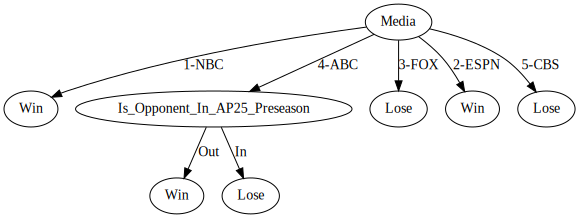

In [110]:
##############################################################################################################
# Q1.2 - decision tree graph / Q1.1 - training id3 decision tree classifier
##############################################################################################################
id3_classifier = DecisionTree(task5_training_set, task5_categorical_attrs, algo=DecisionTree.ID3_ALGORITHM)
id3_classifier.fit()
id3_classifier.render()
##############################################################################################################

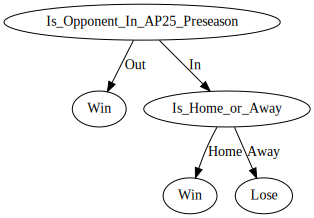

In [111]:
##############################################################################################################
# Q2.2 - decision tree graph / Q2.1 - training c4.5 decision tree classifier
##############################################################################################################
c45_classifier = DecisionTree(task5_training_set, task5_categorical_attrs, algo=DecisionTree.C45_ALGORITHM)
c45_classifier.fit()
c45_classifier.render()
##############################################################################################################

In [112]:
##############################################################################################################
# Q1.2 - predicted labels (1=Win, 0=Lose)
##############################################################################################################
y_id3 = (id3_classifier.predict(task5_testing_set) == 'Win').astype(np.int32)
y_id3
##############################################################################################################

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0])

In [113]:
##############################################################################################################
# Q2.2 - predicted labels (1=Win, 0=Lose)
##############################################################################################################
y_c45 = (c45_classifier.predict(task5_testing_set) == 'Win').astype(np.int32)
y_c45
##############################################################################################################

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [114]:
##############################################################################################################
# ground truth values (1=Win, 0=Lose)
##############################################################################################################
y = (np.array(task5_testing_set['Label'], dtype=np.object) == 'Win').astype(np.int32)
y
##############################################################################################################

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [115]:
##############################################################################################################
# writes summary of requested metrics for each classifier to a csv file.
#
# tis useful for displaying the results with pandas (2 lazy to build dataframe object directly)
##############################################################################################################

import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def generate_summary(name, y, y_pred):
    headers = {
        'Accuracy': accuracy_score, 
        'F1 Score': f1_score, 
        'Precision': precision_score, 
        'Recall': recall_score
    }
    
    with open('{}.csv'.format(name), 'w') as summary:
        print(','.join(headers.keys()), file=summary)
        summary.write(','.join(['{:3.3f}'.format(metric(y, y_pred)) for metric in headers.values()]))

generate_summary('id3', y, y_id3)
generate_summary('c45', y, y_c45)

##############################################################################################################

In [116]:
##############################################################################################################
# Q2.1 - summary of c4.5 classifier's accuracy, f1 score, precision, and recall
##############################################################################################################
c45_summary_df = pd.read_csv('c45.csv')
c45_summary_df.head()

,Accuracy,F1 Score,Precision,Recall
0,0.917,0.947,0.9,1.0


In [117]:
##############################################################################################################
# Q1.1 - summary of id3 classifier's accuracy, f1 score, precision, and recall
##############################################################################################################
id3_summary_df = pd.read_csv('id3.csv')
id3_summary_df.head()

,Accuracy,F1 Score,Precision,Recall
0,0.833,0.889,0.889,0.889
